# Tutorial for building a RAG

https://python.langchain.com/docs/tutorials/rag/

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

if not os.environ.get("GOOGLE_API_KEY"):
  raise ValueError("GOOGLE_API_KEY environment variable is not set.")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash-lite", model_provider="google_genai")

In [3]:
type (llm)

langchain_google_genai.chat_models.ChatGoogleGenerativeAI

In [2]:
llm.invoke("Hey, how can you help me today?")

AIMessage(content='I can help you with a wide variety of tasks! To give you the best possible assistance, tell me what you need help with. For example, are you looking for:\n\n*   **Information?** (e.g., "What is the capital of France?")\n*   **Creative Content?** (e.g., "Write a short story about a cat.")\n*   **Summarization?** (e.g., "Summarize the plot of Hamlet.")\n*   **Translation?** (e.g., "Translate \'Hello, how are you?\' into Spanish.")\n*   **Problem Solving?** (e.g., "I\'m planning a trip to Italy, what should I see?")\n*   **Code Generation?** (e.g., "Write a Python function to calculate the factorial of a number.")\n*   **Brainstorming?** (e.g., "Give me some ideas for a new business.")\n*   **Something else?**\n\nThe more specific you are, the better I can understand your needs and provide a helpful response. I\'m ready to help! Just let me know what you\'d like.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'fi

# Parse Web page

In [38]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()

In [66]:
docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistake

In [3]:
print(f"Total characters: {len(docs[0].page_content)}")

Total characters: 43047


In [40]:
print(docs[0].page_content[0:500])  # Display the first 1000 characters of the content



      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In


# Split text into smaller chunks

In [41]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 63 sub-documents.


In [18]:
print(all_splits[1].page_content[0:1000])  # Display the first 500 characters of the first split

Memory

Short-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model to learn.
Long-term memory: This provides the agent with the capability to retain and recall (infinite) information over extended periods, often by leveraging an external vector store and fast retrieval.


Tool use

The agent learns to call external APIs for extra information that is missing from the model weights (often hard to change after pre-training), including current information, code execution capability, access to proprietary information sources and more.





Overview of a LLM-powered autonomous agent system.


# Embed chunks and store in Vector Store

In [45]:
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embeddings = GoogleGenerativeAIEmbeddings(model="gemini-embedding-001")

vector_store = InMemoryVectorStore(embeddings)

In [46]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['8b8f550e-e5f9-440d-8919-70f8bb43ed23', '83eb6971-b6cc-4919-b7d6-9815dac04707', '90c95a34-243c-4fa6-b4c4-d9aafc3f247a']


# Query & Generation

In [59]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
prompt = PromptTemplate.from_template(template)

example_messages = prompt.invoke(
    {"context": "(context goes here)", "question": "(question goes here)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

(context goes here)

Question: (question goes here)

Helpful Answer:


In [60]:
type(prompt)

langchain_core.prompts.prompt.PromptTemplate

In [61]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [62]:
from loguru import logger

def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    
    logger.debug(f"Retrieved {len(retrieved_docs)} documents for question: {state["question"]}")
    for doc in retrieved_docs:
        logger.debug("Document ID: {}", doc.id)
        logger.debug("Document content: {}", doc.page_content[:100])
    
    return {"context": retrieved_docs}

def generate(state: State):
    logger.debug("Generating answer for question: {}", state["question"])
    logger.debug("Generating answer with context: {}", state["context"])
    
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [63]:
from langgraph.graph import START, StateGraph

graph = (
    StateGraph(State)
    .add_sequence([retrieve, generate])
    .add_edge(START, "retrieve")
    .compile()
)

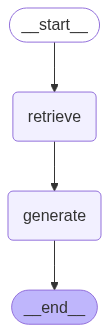

In [64]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke the graph with a sample question

In [65]:
result = graph.invoke({"question": "What is Task Decomposition?"})

print(f"Context: {result['context']}\n\n")
print(f"Answer: {result['answer']}")

2025-07-25 12:36:27.124 | DEBUG    | __main__:retrieve:6 - Retrieved 4 documents for question: What is Task Decomposition?
2025-07-25 12:36:27.125 | DEBUG    | __main__:retrieve:8 - Document ID: 9d3e17b5-11db-4abe-8284-bfcefe1583d7
2025-07-25 12:36:27.125 | DEBUG    | __main__:retrieve:9 - Document content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are
2025-07-25 12:36:27.125 | DEBUG    | __main__:retrieve:8 - Document ID: 90c95a34-243c-4fa6-b4c4-d9aafc3f247a
2025-07-25 12:36:27.126 | DEBUG    | __main__:retrieve:9 - Document content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what
2025-07-25 12:36:27.126 | DEBUG    | __main__:retrieve:8 - Document ID: 977c462c-ae95-4fb4-b5fe-fa3afae052be
2025-07-25 12:36:27.126 | DEBUG    | __main__:retrieve:9 - Document content: Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and 
2025-07-25 12:36

Context: [Document(id='9d3e17b5-11db-4abe-8284-bfcefe1583d7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to an external tool,

## Stream Steps

In [57]:
for step in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

2025-07-25 12:34:09.954 | DEBUG    | __main__:retrieve:6 - Retrieved 4 documents for question: What is Task Decomposition?
2025-07-25 12:34:09.955 | DEBUG    | __main__:retrieve:8 - Document ID: 9d3e17b5-11db-4abe-8284-bfcefe1583d7
2025-07-25 12:34:09.955 | DEBUG    | __main__:retrieve:9 - Document content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are
2025-07-25 12:34:09.955 | DEBUG    | __main__:retrieve:8 - Document ID: 90c95a34-243c-4fa6-b4c4-d9aafc3f247a
2025-07-25 12:34:09.956 | DEBUG    | __main__:retrieve:9 - Document content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what
2025-07-25 12:34:09.956 | DEBUG    | __main__:retrieve:8 - Document ID: 977c462c-ae95-4fb4-b5fe-fa3afae052be
2025-07-25 12:34:09.956 | DEBUG    | __main__:retrieve:9 - Document content: Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and 
2025-07-25 12:34

{'retrieve': {'context': [Document(id='9d3e17b5-11db-4abe-8284-bfcefe1583d7', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'start_index': 2578}, page_content='Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\\n1.", "What are the subgoals for achieving XYZ?", (2) by using task-specific instructions; e.g. "Write a story outline." for writing a novel, or (3) with human inputs.\nAnother quite distinct approach, LLM+P (Liu et al. 2023), involves relying on an external classical planner to do long-horizon planning. This approach utilizes the Planning Domain Definition Language (PDDL) as an intermediate interface to describe the planning problem. In this process, LLM (1) translates the problem into “Problem PDDL”, then (2) requests a classical planner to generate a PDDL plan based on an existing “Domain PDDL”, and finally (3) translates the PDDL plan back into natural language. Essentially, the planning step is outsourced to a

## Stream tokens

In [58]:
for message, metadata in graph.stream(
    {"question": "What is Task Decomposition?"}, stream_mode="messages"
):
    print(message.content, end="|")

2025-07-25 12:35:04.040 | DEBUG    | __main__:retrieve:6 - Retrieved 4 documents for question: What is Task Decomposition?
2025-07-25 12:35:04.043 | DEBUG    | __main__:retrieve:8 - Document ID: 9d3e17b5-11db-4abe-8284-bfcefe1583d7
2025-07-25 12:35:04.043 | DEBUG    | __main__:retrieve:9 - Document content: Task decomposition can be done (1) by LLM with simple prompting like "Steps for XYZ.\n1.", "What are
2025-07-25 12:35:04.044 | DEBUG    | __main__:retrieve:8 - Document ID: 90c95a34-243c-4fa6-b4c4-d9aafc3f247a
2025-07-25 12:35:04.044 | DEBUG    | __main__:retrieve:9 - Document content: Component One: Planning#
A complicated task usually involves many steps. An agent needs to know what
2025-07-25 12:35:04.044 | DEBUG    | __main__:retrieve:8 - Document ID: 977c462c-ae95-4fb4-b5fe-fa3afae052be
2025-07-25 12:35:04.044 | DEBUG    | __main__:retrieve:9 - Document content: Short-Term Memory (STM) or Working Memory: It stores information that we are currently aware of and 
2025-07-25 12:35

Task| decomposition involves| breaking down a complex task into smaller, more manageable steps. This can be done using| Large Language Models (LLMs) with prompting, task-specific instructions, or with| human input. Techniques like Chain of Thought and Tree of Thoughts are used for task decomposition.
|